## CSIRO Image2Biomass – 5-Head Model Inference

This notebook runs inference using the 5-Head DINOv2 model with:
- FiLM cross-stream conditioning
- Attention pooling over tiles  
- 5 independent regression heads (Green, Dead, Clover, GDM, Total)
- TTA (Test-Time Augmentation) with flips
- K-fold ensemble
- **Log target support** (expm1 inverse transform)
- **Dead derivation fix** (Dead = Total - GDM)
- **Species auxiliary head** (8 classes)

/root/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded config from results.json:
  backbone: vit_base_patch14_reg4_dinov2.lvd142m
  grid: [2, 2]
  use_log_target: False
  stereo_correct_aug: True
5-Head DINOv2 Inference
Device: cuda
Backbone: vit_base_patch14_reg4_dinov2.lvd142m
Model dir: /root/workspace/biomass-kaggle/outputs/5head_20251215_064717
Grid: (2, 2)
Log target: False
Derive Dead: False
TTA: True

================= Loading test data =================
Found 357 unique test images.

================= Configuration =================
Log target: False
Derive Dead: False
TTA: True

================= Loading 5-head model =================
Backbone: vit_base_patch14_reg4_dinov2.lvd142m
Model dir: /root/workspace/biomass-kaggle/outputs/5head_20251215_064717
Found 5 fold checkpoints
  Loading fold 0: 5head_best_fold0.pth
  Loading fold 1: 5head_best_fold1.pth
  Loading fold 2: 5head_best_fold2.pth
  Loading fold 3: 5head_best_fold3.pth
  Loading fold 4: 5head_best_fold4.pth
Input resolution: 518
FiLM: True, AttnPool: True, AuxHea


--- TTA view 2/3 (hflip, resize=518) ---



--- TTA view 3/3 (vflip, resize=518) ---



🎉 Generated submission file: submission.csv
                    sample_id     target
0  ID1011485656__Dry_Clover_g   1.867905
1    ID1011485656__Dry_Dead_g  15.856781
2   ID1011485656__Dry_Green_g  23.907293
3   ID1011485656__Dry_Total_g  44.899998
4         ID1011485656__GDM_g  26.893751

================= Generating Visualizations =================


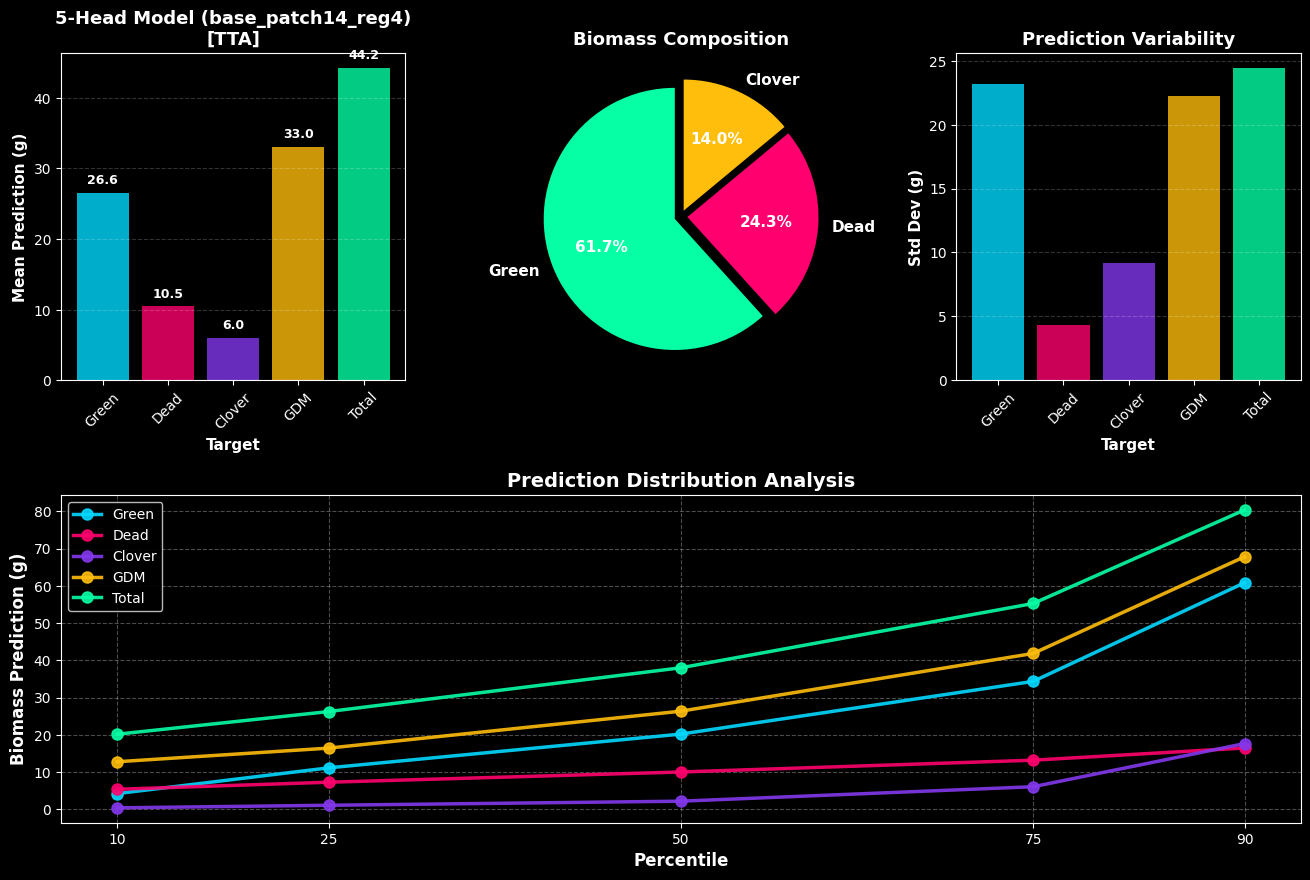


📊 Visualization saved: 5head_predictions.png


In [ ]:
import os
import gc
import json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec


class CFG:
    """Configuration for 5-head model inference."""
    
    # ==================== LOCAL TESTING MODE ====================
    # Set LOCAL_TEST = True for local testing, False for Kaggle submission
    LOCAL_TEST = True
    
    if LOCAL_TEST:
        BASE_PATH = "/root/workspace/biomass-kaggle/data"
        TEST_CSV = os.path.join(BASE_PATH, "train.csv")  # Use train.csv for local OOF testing
        TEST_IMAGE_DIR = os.path.join(BASE_PATH, "train")
        # ⚠️ UPDATE THIS to your latest training output directory
        MODEL_DIR = "/root/workspace/biomass-kaggle/outputs/5head_20251215_064717"
    else:
        BASE_PATH = "/kaggle/input/csiro-biomass"
        TEST_CSV = os.path.join(BASE_PATH, "test.csv")
        TEST_IMAGE_DIR = os.path.join(BASE_PATH, "test")
        MODEL_DIR = "/kaggle/input/your-model-dataset"  # Update for Kaggle
    
    # Backbone config (must match training)
    BACKBONE = "vit_base_patch14_reg4_dinov2.lvd142m"
    
    # ==================== INFERENCE SETTINGS ====================
    SUBMISSION_FILE = "submission.csv"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 1
    NUM_WORKERS = 0
    
    # Model architecture params (auto-loaded from results.json if available)
    DROPOUT = 0.2
    HIDDEN_RATIO = 0.5
    GRID = (2, 2)
    USE_FILM = True
    USE_ATTENTION_POOL = True
    USE_AUX_HEADS = True  # Model trained with --use-aux-heads
    
    # ==================== NEW FEATURES ====================
    # Log target: Set True if model trained with --use-log-target
    USE_LOG_TARGET = False  # Not using log target
    
    # Dead derivation: Apply Dead = max(0, Total - GDM) post-processing
    DERIVE_DEAD = True  # Derive Dead from Total - GDM
    
    # TTA settings
    USE_TTA = True  # Enable Test-Time Augmentation (3 views)
    
    ALL_TARGET_COLS = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]
    
    # DINO backbone candidates for auto-detection (fallback)
    DINO_CANDIDATES = [
        "vit_large_patch14_reg4_dinov2.lvd142m",
        "vit_base_patch14_reg4_dinov2.lvd142m",
        "vit_small_patch14_reg4_dinov2.lvd142m",
        "vit_large_patch14_dinov2.lvd142m",
        "vit_base_patch14_dinov2.lvd142m",
        "vit_small_patch14_dinov2.lvd142m",
    ]


def find_latest_model_dir(outputs_dir: str = "./outputs", prefix: str = "5head_") -> Optional[str]:
    """Find the most recent model directory by timestamp in name."""
    if not os.path.exists(outputs_dir):
        return None
    dirs = [d for d in os.listdir(outputs_dir) if d.startswith(prefix) and os.path.isdir(os.path.join(outputs_dir, d))]
    if not dirs:
        return None
    # Sort by name (timestamp format YYYYMMDD_HHMMSS ensures correct ordering)
    dirs.sort(reverse=True)
    return os.path.join(outputs_dir, dirs[0])


def load_config_from_results(model_dir: str) -> Dict:
    """Load training config from results.json if available."""
    results_path = os.path.join(model_dir, "results.json")
    if os.path.exists(results_path):
        with open(results_path, "r") as f:
            results = json.load(f)
        config = results.get("config", {})
        print(f"Loaded config from results.json:")
        for key in ["backbone", "grid", "use_log_target", "stereo_correct_aug"]:
            if key in config:
                print(f"  {key}: {config[key]}")
        return config
    return {}


# Auto-find latest model directory if configured one doesn't exist
if not os.path.exists(CFG.MODEL_DIR):
    _latest = find_latest_model_dir("./outputs", "5head_")
    if _latest:
        print(f"⚠️ MODEL_DIR not found, using latest: {_latest}")
        CFG.MODEL_DIR = _latest


# Auto-load config from results.json
if os.path.exists(CFG.MODEL_DIR):
    _loaded_config = load_config_from_results(CFG.MODEL_DIR)
    if _loaded_config:
        CFG.BACKBONE = _loaded_config.get("backbone", CFG.BACKBONE)
        CFG.GRID = tuple(_loaded_config.get("grid", CFG.GRID))
        CFG.DROPOUT = _loaded_config.get("dropout", CFG.DROPOUT)
        CFG.HIDDEN_RATIO = _loaded_config.get("hidden_ratio", CFG.HIDDEN_RATIO)
        CFG.USE_LOG_TARGET = _loaded_config.get("use_log_target", CFG.USE_LOG_TARGET)


def get_device() -> torch.device:
    """Get best available device."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


# Update device
CFG.DEVICE = get_device()


def get_all_fold_checkpoints(model_dir: str, num_folds: int = 5) -> List[str]:
    """Get checkpoint paths for all folds of 5-head model."""
    paths = []
    for fold in range(num_folds):
        ckpt_path = os.path.join(model_dir, f"5head_best_fold{fold}.pth")
        if os.path.exists(ckpt_path):
            paths.append(ckpt_path)
        else:
            print(f"  Warning: {ckpt_path} not found, skipping")
    return paths


print("="*60)
print("5-Head DINOv2 Inference")
print("="*60)
print(f"Device: {CFG.DEVICE}")
print(f"Backbone: {CFG.BACKBONE}")
print(f"Model dir: {CFG.MODEL_DIR}")
print(f"Grid: {CFG.GRID}")
print(f"Log target: {CFG.USE_LOG_TARGET}")
print(f"Derive Dead: {CFG.DERIVE_DEAD}")
print(f"TTA: {CFG.USE_TTA}")
print("="*60)

class TestBiomassDataset(Dataset):
    def __init__(self, df, transform, image_dir):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_dir = image_dir
        self.paths = self.df["image_path"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = os.path.basename(self.paths[idx])
        full_path = os.path.join(self.image_dir, filename)
        img = cv2.imread(full_path)
        if img is None:
            img = np.zeros((1000, 2000, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape
        mid = w // 2
        left = img[:, :mid]
        right = img[:, mid:]

        left_t = self.transform(image=left)["image"]
        right_t = self.transform(image=right)["image"]
        return left_t, right_t

def _infer_input_res(m) -> int:
    if hasattr(m, "patch_embed") and hasattr(m.patch_embed, "img_size"):
        isz = m.patch_embed.img_size
        return int(isz if isinstance(isz, (int, float)) else isz[0])
    if hasattr(m, "img_size"):
        isz = m.img_size
        return int(isz if isinstance(isz, (int, float)) else isz[0])
    dc = getattr(m, "default_cfg", {}) or {}
    ins = dc.get("input_size", None)
    if ins:
        if isinstance(ins, (tuple, list)) and len(ins) >= 2:
            return int(ins[1])
        return int(ins if isinstance(ins, (int, float)) else 224)
    name = getattr(m, "default_cfg", {}).get("architecture", "") or str(type(m))
    if "dinov2" in name.lower():
        return 518
    return 224

def _build_dino_by_name(name: str, pretrained: bool = False):
    m = timm.create_model(name, pretrained=pretrained, num_classes=0)
    feat = m.num_features
    input_res = _infer_input_res(m)
    return m, feat, input_res

def _make_edges(L: int, parts: int) -> List[Tuple[int, int]]:
    step = L // parts
    edges = []
    start = 0
    for _ in range(parts - 1):
        edges.append((start, start + step))
        start += step
    edges.append((start, L))
    return edges


class FiLM(nn.Module):
    """Feature-wise Linear Modulation layer."""
    
    def __init__(self, in_dim: int) -> None:
        super().__init__()
        hidden = max(64, in_dim // 2)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, in_dim * 2),
        )
    
    def forward(self, context: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gb = self.mlp(context)
        gamma, beta = torch.chunk(gb, 2, dim=1)
        return gamma, beta


class AttentionPooling(nn.Module):
    """Learnable attention pooling over tiles."""
    
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.scale = dim ** -0.5
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        q = self.query(x.mean(dim=1, keepdim=True))  # (B, 1, D)
        k = self.key(x)  # (B, T, D)
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, 1, T)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ x).squeeze(1)  # (B, D)
        return out


# Auxiliary head constants
NUM_STATES = 4
NUM_MONTHS = 10
NUM_SPECIES = 8  # Added: Species classification head


class FiveHeadDINO(nn.Module):
    """
    5-Head DINOv2 model with FiLM conditioning and attention pooling.
    All 5 biomass targets are predicted independently.
    """
    
    def __init__(
        self,
        backbone_name: str = "vit_base_patch14_reg4_dinov2.lvd142m",
        grid: Tuple[int, int] = (2, 2),
        pretrained: bool = False,
        dropout: float = 0.2,
        hidden_ratio: float = 0.5,
        use_film: bool = True,
        use_attention_pool: bool = True,
        use_aux_heads: bool = False,
    ) -> None:
        super().__init__()
        
        self.backbone, feat_dim, input_res = _build_dino_by_name(backbone_name, pretrained)
        self.used_backbone_name = backbone_name
        self.input_res = int(input_res)
        self.feat_dim = feat_dim
        self.grid = tuple(grid)
        self.use_film = use_film
        self.use_attention_pool = use_attention_pool
        self.use_aux_heads = use_aux_heads
        
        # FiLM for left-right stream conditioning
        if use_film:
            self.film_left = FiLM(feat_dim)
            self.film_right = FiLM(feat_dim)
        
        # Attention pooling for tiles
        if use_attention_pool:
            self.attn_pool_left = AttentionPooling(feat_dim)
            self.attn_pool_right = AttentionPooling(feat_dim)
        
        # Combined features from left + right streams
        self.combined_dim = feat_dim * 2
        hidden_dim = max(64, int(self.combined_dim * hidden_ratio))
        self.hidden_dim = hidden_dim
        
        # Shared feature projection with LayerNorm
        self.shared_proj = nn.Sequential(
            nn.LayerNorm(self.combined_dim),
            nn.Linear(self.combined_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        
        def _make_head(in_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, in_dim),
                nn.GELU(),
                nn.Dropout(dropout * 0.5),
                nn.Linear(in_dim, 1),
            )
        
        # 5 independent heads for biomass targets
        self.head_green = _make_head(hidden_dim)
        self.head_dead = _make_head(hidden_dim)
        self.head_clover = _make_head(hidden_dim)
        self.head_gdm = _make_head(hidden_dim)
        self.head_total = _make_head(hidden_dim)
        
        # Auxiliary heads for State, Month, and Species classification
        if use_aux_heads:
            self.head_state = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, NUM_STATES),
            )
            self.head_month = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, NUM_MONTHS),
            )
            self.head_species = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, NUM_SPECIES),
            )
        
        self.softplus = nn.Softplus(beta=1.0)
    
    def _collect_tiles(self, x: torch.Tensor) -> List[torch.Tensor]:
        _, C, H, W = x.shape
        r, c = self.grid
        rows = _make_edges(H, r)
        cols = _make_edges(W, c)
        tiles = []
        for rs, re in rows:
            for cs, ce in cols:
                xt = x[:, :, rs:re, cs:ce]
                if xt.shape[-2:] != (self.input_res, self.input_res):
                    xt = F.interpolate(xt, size=(self.input_res, self.input_res), 
                                       mode="bilinear", align_corners=False)
                tiles.append(xt)
        return tiles

    def _extract_tiles_fused(self, x_left: torch.Tensor, x_right: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Extract tile features from BOTH streams in ONE backbone call."""
        B = x_left.size(0)
        tiles_left = self._collect_tiles(x_left)
        tiles_right = self._collect_tiles(x_right)
        num_tiles = len(tiles_left)
        
        all_tiles = torch.cat(tiles_left + tiles_right, dim=0)
        all_feats = self.backbone(all_tiles)
        
        total_tiles = 2 * num_tiles
        all_feats = all_feats.view(total_tiles, B, -1).permute(1, 0, 2)
        feats_left = all_feats[:, :num_tiles, :]
        feats_right = all_feats[:, num_tiles:, :]
        return feats_left, feats_right

    def forward(self, x_left: torch.Tensor, x_right: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        # Extract tile features
        tiles_left, tiles_right = self._extract_tiles_fused(x_left, x_right)
        
        # Get initial context
        ctx_left = tiles_left.mean(dim=1)
        ctx_right = tiles_right.mean(dim=1)
        
        # Apply FiLM cross-conditioning
        if self.use_film:
            gamma_l, beta_l = self.film_left(ctx_right)
            gamma_r, beta_r = self.film_right(ctx_left)
            tiles_left = tiles_left * (1 + gamma_l.unsqueeze(1)) + beta_l.unsqueeze(1)
            tiles_right = tiles_right * (1 + gamma_r.unsqueeze(1)) + beta_r.unsqueeze(1)
        
        # Pool tiles
        if self.use_attention_pool:
            f_l = self.attn_pool_left(tiles_left)
            f_r = self.attn_pool_right(tiles_right)
        else:
            f_l = tiles_left.mean(dim=1)
            f_r = tiles_right.mean(dim=1)
        
        # Combine and project
        f = torch.cat([f_l, f_r], dim=1)
        f = self.shared_proj(f)
        
        # All 5 predictions are independent
        green = self.softplus(self.head_green(f))
        dead = self.softplus(self.head_dead(f))
        clover = self.softplus(self.head_clover(f))
        gdm = self.softplus(self.head_gdm(f))
        total = self.softplus(self.head_total(f))
        
        return green, dead, clover, gdm, total

def _strip_module_prefix(sd: dict) -> dict:
    if not sd:
        return sd
    keys = list(sd.keys())
    if all(k.startswith("module.") for k in keys):
        return {k[len("module."):]: v for k, v in sd.items()}
    return sd


def _detect_model_config(sd_keys: set) -> dict:
    """Detect model configuration from state dict keys."""
    config = {
        "use_film": any(k.startswith("film_left.") or k.startswith("film_right.") for k in sd_keys),
        "use_attention_pool": any(k.startswith("attn_pool_left.") or k.startswith("attn_pool_right.") for k in sd_keys),
        "use_aux_heads": any(k.startswith("head_state.") or k.startswith("head_month.") or k.startswith("head_species.") for k in sd_keys),
        "has_species_head": any(k.startswith("head_species.") for k in sd_keys),
        "is_5head": any(k.startswith("head_gdm.") for k in sd_keys) or any(k.startswith("shared_proj.") for k in sd_keys),
    }
    return config


def load_fold_model(
    path: str, 
    backbone_name: str,
    grid: Tuple[int, int] = (2, 2),
    use_film: bool = True,
    use_attention_pool: bool = True,
    use_aux_heads: bool = False,
) -> FiveHeadDINO:
    """
    Load a 5-head model checkpoint.
    
    Args:
        path: Path to the checkpoint file
        backbone_name: Backbone model name
        grid: Tile grid configuration
        use_film: Whether to use FiLM conditioning
        use_attention_pool: Whether to use attention pooling
        use_aux_heads: Whether model has auxiliary heads
    
    Returns:
        Loaded model in eval mode
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")
    
    # Load state dict
    try:
        raw_sd = torch.load(path, map_location=CFG.DEVICE, weights_only=True)
    except TypeError:
        raw_sd = torch.load(path, map_location=CFG.DEVICE)
    
    sd = _strip_module_prefix(raw_sd)
    
    # Auto-detect config from state dict
    detected = _detect_model_config(set(sd.keys()))
    use_film = detected["use_film"] if detected["use_film"] else use_film
    use_attention_pool = detected["use_attention_pool"] if detected["use_attention_pool"] else use_attention_pool
    use_aux_heads = detected["use_aux_heads"]
    
    # Build model
    model = FiveHeadDINO(
        backbone_name=backbone_name,
        grid=grid,
        pretrained=False,
        dropout=CFG.DROPOUT,
        hidden_ratio=CFG.HIDDEN_RATIO,
        use_film=use_film,
        use_attention_pool=use_attention_pool,
        use_aux_heads=use_aux_heads,
    )
    
    # Load weights
    result = model.load_state_dict(sd, strict=False)
    missing = getattr(result, "missing_keys", [])
    unexpected = getattr(result, "unexpected_keys", [])
    
    if missing:
        print(f"  Warning: Missing keys: {missing[:5]}{'...' if len(missing) > 5 else ''}")
    if unexpected:
        print(f"  Warning: Unexpected keys: {unexpected[:5]}{'...' if len(unexpected) > 5 else ''}")
    
    model.to(CFG.DEVICE)
    model.eval()
    
    return model

def get_tta_transforms(img_size: int):
    base = [A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]
    original = A.Compose([A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    hflip = A.Compose([A.HorizontalFlip(p=1.0), A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    vflip = A.Compose([A.VerticalFlip(p=1.0), A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    return [original, hflip, vflip]

@torch.no_grad()
def predict_one_view(models: List[nn.Module], loader: DataLoader) -> np.ndarray:
    """Run inference for a single TTA view with fold ensemble."""
    out_list = []
    
    # Set up AMP based on device
    use_amp = CFG.DEVICE.type == "cuda"
    amp_device = "cuda" if use_amp else "cpu"

    for (xl, xr) in tqdm(loader, desc="  Predicting", leave=False):
        xl = xl.to(CFG.DEVICE, non_blocking=True)
        xr = xr.to(CFG.DEVICE, non_blocking=True)

        per_model_preds = []
        with torch.amp.autocast(amp_device, enabled=use_amp):
            for m in models:
                green, dead, clover, gdm, total = m(xl, xr)
                five = torch.cat([green, dead, clover, gdm, total], dim=1)
                five = torch.clamp(five, min=0.0)
                per_model_preds.append(five.float().cpu())

        # Average across folds
        stacked = torch.mean(torch.stack(per_model_preds, dim=0), dim=0)
        out_list.append(stacked.numpy())

    return np.concatenate(out_list, axis=0)

def get_val_transform(img_size: int) -> A.Compose:
    """Get standard validation transform (no TTA)."""
    return A.Compose([
        A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def run_5head_inference(model_dir: str, backbone_name: str, test_unique, image_dir):
    """Run inference for all folds of 5-head model with optional TTA."""
    ckpt_list = get_all_fold_checkpoints(model_dir)
    print(f"\n================= Loading 5-head model =================")
    print(f"Backbone: {backbone_name}")
    print(f"Model dir: {model_dir}")
    print(f"Found {len(ckpt_list)} fold checkpoints")
    
    if len(ckpt_list) == 0:
        raise RuntimeError(f"No checkpoints found in {model_dir}")
    
    # Load all fold models
    models = []
    for i, ckpt_path in enumerate(ckpt_list):
        print(f"  Loading fold {i}: {os.path.basename(ckpt_path)}")
        model = load_fold_model(
            ckpt_path,
            backbone_name=backbone_name,
            grid=CFG.GRID,
            use_film=CFG.USE_FILM,
            use_attention_pool=CFG.USE_ATTENTION_POOL,
            use_aux_heads=CFG.USE_AUX_HEADS,
        )
        models.append(model)
    
    backbone_res = int(getattr(models[0], "input_res", 518))
    print(f"Input resolution: {backbone_res}")
    print(f"FiLM: {models[0].use_film}, AttnPool: {models[0].use_attention_pool}, AuxHeads: {models[0].use_aux_heads}")
    
    if CFG.USE_TTA:
        # TTA inference (3 views: original, hflip, vflip)
        tta_trans = get_tta_transforms(backbone_res)
        per_view_preds = []
        
        for i, t in enumerate(tta_trans):
            view_name = ["original", "hflip", "vflip"][i]
            print(f"\n--- TTA view {i+1}/{len(tta_trans)} ({view_name}, resize={backbone_res}) ---")
            ds = TestBiomassDataset(test_unique, t, image_dir)
            dl = DataLoader(ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
            view_5 = predict_one_view(models, dl)
            per_view_preds.append(view_5)
        
        # Average TTA predictions
        final_5 = np.mean(per_view_preds, axis=0)
    else:
        # Single view inference (no TTA)
        print(f"\n--- Single view inference (no TTA, resize={backbone_res}) ---")
        transform = get_val_transform(backbone_res)
        ds = TestBiomassDataset(test_unique, transform, image_dir)
        dl = DataLoader(ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
        final_5 = predict_one_view(models, dl)
    
    # Free GPU memory
    del models
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return final_5


def derive_dead_from_total_gdm(preds: np.ndarray) -> np.ndarray:
    """
    Derive Dead = Total - GDM.
    
    Since Total = Green + Dead + Clover and GDM = Green + Clover,
    then Dead = Total - GDM.
    
    Args:
        preds: (N, 5) array [Green, Dead, Clover, GDM, Total]
    
    Returns:
        Modified preds with Dead replaced by max(0, Total - GDM)
    """
    preds_fixed = preds.copy()
    total = preds[:, 4]
    gdm = preds[:, 3]
    dead_derived = np.maximum(0, total - gdm)
    preds_fixed[:, 1] = dead_derived
    return preds_fixed


def run_inference():
    """Run 5-head model inference with all post-processing."""
    print("\n================= Loading test data =================")
    test_long = pd.read_csv(CFG.TEST_CSV)
    test_unique = test_long.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
    print(f"Found {len(test_unique)} unique test images.")
    
    print(f"\n================= Configuration =================")
    print(f"Log target: {CFG.USE_LOG_TARGET}")
    print(f"Derive Dead: {CFG.DERIVE_DEAD}")
    print(f"TTA: {CFG.USE_TTA}")
    
    # Run inference
    final_5 = run_5head_inference(CFG.MODEL_DIR, CFG.BACKBONE, test_unique, CFG.TEST_IMAGE_DIR)
    
    # Apply inverse log transform if model was trained with log targets
    if CFG.USE_LOG_TARGET:
        print("\n================= Applying expm1 (inverse log1p) =================")
        final_5 = np.expm1(final_5)
        final_5 = np.maximum(0, final_5)  # Ensure non-negative
    
    # Apply Dead derivation fix
    if CFG.DERIVE_DEAD:
        print("\n================= Applying Dead derivation fix =================")
        print("Dead = max(0, Total - GDM)")
        final_5 = derive_dead_from_total_gdm(final_5)
    
    return final_5, test_long, test_unique

def create_submission(final_5, test_long, test_unique):
    green = final_5[:, 0]
    dead = final_5[:, 1]
    clover = final_5[:, 2]
    gdm = final_5[:, 3]
    total = final_5[:, 4]

    def nnz(x):
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        return np.maximum(0, x)

    green, dead, clover, gdm, total = map(nnz, [green, dead, clover, gdm, total])

    wide = pd.DataFrame(
        {
            "image_path": test_unique["image_path"],
            "Dry_Green_g": green,
            "Dry_Dead_g": dead,
            "Dry_Clover_g": clover,
            "GDM_g": gdm,
            "Dry_Total_g": total,
        }
    )

    long_preds = wide.melt(
        id_vars=["image_path"],
        value_vars=CFG.ALL_TARGET_COLS,
        var_name="target_name",
        value_name="target",
    )

    sub = pd.merge(
        test_long[["sample_id", "image_path", "target_name"]],
        long_preds,
        on=["image_path", "target_name"],
        how="left",
    )[["sample_id", "target"]]

    sub["target"] = np.nan_to_num(sub["target"], nan=0.0, posinf=0.0, neginf=0.0)
    sub.to_csv(CFG.SUBMISSION_FILE, index=False)
    print(f"\n🎉 Generated submission file: {CFG.SUBMISSION_FILE}")
    print(sub.head())
    return sub, wide

def visualize_predictions(final_5, wide_df):
    """Visualize 5-head model predictions."""
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    colors = ['#00d9ff', '#ff006e', '#8338ec', '#ffbe0b', '#06ffa5']
    target_names = ['Green', 'Dead', 'Clover', 'GDM', 'Total']
    
    # Model info
    backbone_short = CFG.BACKBONE.replace("vit_", "").replace("_dinov2.lvd142m", "").replace("_dinov2", "")
    features = []
    if CFG.USE_LOG_TARGET:
        features.append("log")
    if CFG.DERIVE_DEAD:
        features.append("dead_fix")
    if CFG.USE_TTA:
        features.append("TTA")
    features_str = ", ".join(features) if features else "none"
    
    # Mean predictions per target
    ax1 = fig.add_subplot(gs[0, 0])
    means = [final_5[:, i].mean() for i in range(5)]
    bars = ax1.bar(target_names, means, color=colors, alpha=0.8)
    ax1.set_xlabel('Target', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Mean Prediction (g)', fontsize=11, fontweight='bold')
    ax1.set_title(f'5-Head Model ({backbone_short})\n[{features_str}]', fontsize=13, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.2, linestyle='--')
    for bar, val in zip(bars, means):
        ax1.text(bar.get_x() + bar.get_width()/2, val + max(means)*0.02, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Biomass composition pie chart
    ax2 = fig.add_subplot(gs[0, 1])
    biomass_totals = wide_df[['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g']].sum()
    wedges, texts, autotexts = ax2.pie(biomass_totals, labels=['Green', 'Dead', 'Clover'],
                                         autopct='%1.1f%%', startangle=90,
                                         colors=['#06ffa5', '#ff006e', '#ffbe0b'],
                                         explode=(0.05, 0.05, 0.05),
                                         textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Biomass Composition', fontsize=13, fontweight='bold')
    
    # Standard deviation per target
    ax3 = fig.add_subplot(gs[0, 2])
    stds = [final_5[:, i].std() for i in range(5)]
    bars = ax3.bar(target_names, stds, color=colors, alpha=0.8)
    ax3.set_xlabel('Target', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Std Dev (g)', fontsize=11, fontweight='bold')
    ax3.set_title('Prediction Variability', fontsize=13, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.2, linestyle='--')
    
    # Distribution percentiles
    ax4 = fig.add_subplot(gs[1, :])
    percentiles = [10, 25, 50, 75, 90]
    for i, name in enumerate(target_names):
        values = final_5[:, i]
        perc_values = np.percentile(values, percentiles)
        ax4.plot(percentiles, perc_values, marker='o', linewidth=2.5, 
                label=name, color=colors[i], markersize=8, alpha=0.9)
    ax4.set_xlabel('Percentile', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Biomass Prediction (g)', fontsize=12, fontweight='bold')
    ax4.set_title('Prediction Distribution Analysis', fontsize=14, fontweight='bold')
    ax4.legend(loc='best', framealpha=0.9, fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_xticks(percentiles)
    
    plt.savefig('5head_predictions.png', dpi=150, bbox_inches='tight', 
                facecolor='#1a1a1a', edgecolor='none')
    plt.show()
    print("\n📊 Visualization saved: 5head_predictions.png")


if __name__ == "__main__":
    # Run inference
    final_5, df_long, df_unique = run_inference()
    
    # Create submission
    sub, wide_df = create_submission(final_5, df_long, df_unique)
    
    # Visualize
    print("\n================= Generating Visualizations =================")
    visualize_predictions(final_5, wide_df)
    
    # Cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()